## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, We will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# importing pandas, numpy , random and maplotlib

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# reading the dataset using pandas 'read_csv' function
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# The number of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# The number of unique users in the dataset
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# The proportion of users converted
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# The users in treatment group but landed on old page
treated_but_old = df.query('group == "treatment" & landing_page != "new_page"')

# # The users in control group but landed on new page
control_but_new = df.query('group != "treatment" & landing_page == "new_page"')

# The number of times the new_page and treatment don't line up. 
len(treated_but_old) + len(control_but_new)

3893

f. Do any of the rows have missing values?

In [7]:
# We will see if there are any rows with missing values using 'info' function
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. So to make an unbiased analysis we will remove these rows. We will Store our new dataframe in **df2**.

In [8]:
# We will create a temporary table for the rows where treatment is not aligned with new_page or control is 
# not aligned with old_page, We will drop these rows and store the results in df2 for further analysis.

temp_df = treated_but_old.append(control_but_new).index
df2 = df.drop(temp_df)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
# No. of unique user_ids in df2
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# Duplicated user id in df2

df2[df2.user_id.duplicated()==True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
# Row information for duplicated user id: 773192
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# removing the user id 773192 from 2893 label
df2.drop(labels=2893, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# probability of an individual converting given that an individual was in the control group
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# probability of an individual converting given that an individual was in the treatment group
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
# probability that an individual received the new page
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

####  Part I - conclusion

> 1. The probability that an indivisual received the new page is approximately half. this suggest that half of the population received the old page and remaining half received new page. The population size (290584) is considerable. so our results won't be biased.

> 2. Now, We can see 12.04% population that received the old_page were converted and 11.88% population that received the new_page were converted. So, there is not sufficient evidence to say that the new treatment page leads to more conversions. We can conclude that, the new_page did not increase the conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 1. Null hypothesis: the conversion rate of the old_page is greater or the same than the conversion rate of the newpage.
           
 $\ H_{0}: P_{old} >= P_{new} $ <br>
 $\ H_{0}: P_{new} - P_{old} <= 0 $ <br>
 
 2. Alternative hypothesis: the conversion rate of the old_page is less than the conversion rate of the newpage
 
  $\ H_{1}: P_{new} - P_{old} > 0 $

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
# Null hypothesis does not change convert rate. therefore, Covert rate is same as overall convert rate
P_new = df2.converted.mean()
P_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
# Null hypothesis does not change convert rate. therefore, Covert rate is same as overall convert rate
P_old = df2.converted.mean()
P_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
# number of users landed on new_page
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [21]:
# number of users landed on old
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Simulating  𝑛𝑛𝑒𝑤  transactions 
new_page_converted = np.random.choice([1, 0], size=n_new, p=[P_new, (1-P_new)])
new_page_converted.mean()

0.12027389718532792

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Simulating  𝑛old  transactions
old_page_converted = np.random.choice([1, 0], size=n_old, p=[P_old, (1-P_old)])
old_page_converted.mean()

0.1190577804700084

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# Finding  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  for our simulated values from above parts.
new_page_converted.mean() - old_page_converted.mean()

0.001216116715319529

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# run simulation 10000 times
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,P_new,n_new).mean()
    old_page_converted = np.random.binomial(1,P_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)

In [26]:
# Storing all 10,000 values in a numpy array called p_diffs.
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [27]:
# calculating obs_diff
df_control = df2.query('group == "control"')
df_treatment = df2.query('group == "treatment"')


obs_diff = df_treatment.converted.mean() - df_control.converted.mean()
obs_diff

-0.0015782389853555567

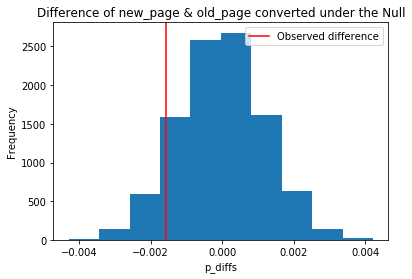

In [28]:
# Plotting a histogram of the p_diffs with matplotlib.
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Difference of new_page & old_page converted under the Null');
plt.legend()
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# calculating and displaying proportion of the p_diffs are greater than the actual difference observed

(p_diffs > obs_diff).mean()

0.9045

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>The p-value calculated is 0.905. This is much larger than the typical $\alpha$ level of 0.05. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new page has a higher conversion rate than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
#Calculate the number of conversions for each page, as well as the number of individuals who received each page. 
#Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> The values we calculated are aligned with those obtained during the bootstrapped hypothesis testing. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page. The z-score and the p_value clearly suggest that one should not reject the null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>  As dependent variable is a binary or dichotomous variable (here, converted vs not converted). Thus, we need to approach this problem with logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
# creating a column for the intercept, and create a dummy variable column for which page each user received.
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
# Instantiating the model, and fitting the model using the two columns we created above
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
# Providing the summary of our model
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:22:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> The p-value associated with ab_page is 0.1, It is higher than $\alpha$ = 0.05. Thus, the coefficient is not significant. results do not support the alternative hypothesis sufficiently.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> It is a good idea to consider other factors in order to identify other potencial influences on the conversion rate. The disadvantage would be that model will get more complex to analyse.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
#reading the 'countries.csv' dataset
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [36]:
### Confirming unique values in country column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [37]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [38]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:               1.521e-05
Time:                        14:22:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

> Even after considering 'country' specific information it is evident from summary that p-values for the countries are well above $\alpha$=0.05 level. We again fail to reject the null. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
# looking at an interaction between page and country to see if there significant effects on conversion
df_new['intercept'] = 1
df_new['CA_Page'] = df_new.CA *df_new.ab_page
df_new['UK_Page'] = df_new.UK *df_new.ab_page

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_Page,UK_Page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [40]:
### Fitting our Linear Model And Obtaining the Results
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','CA_Page','UK','UK_Page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        14:22:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
CA_Page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_Page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

> None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

<a id='conclusions'></a>
## Conclusions

So we can conclude that there is not sufficient evidence that the new page increases the conversion rate than old_page. probability , A/B test and logistic regression regression all points to the same fact that there is no strong evidence that indivisuals from perticular countries influence the conversion rate.

As sample size considered is large enough, it is not required to run the experiment longer to make decision.